In [1506]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel
import optuna

Consolidate Data & Save to Parquet

In [1507]:
# df_train = pd.read_csv(r"./data/train.csv", index_col=0)
# df_test = pd.read_csv(r"./data/test.csv", index_col=0)
# df_transactions = pd.read_csv(r"./data/transactions.csv")
# df_stores = pd.read_csv(r"./data/stores.csv")
# df_holidays = pd.read_csv(r"./data/holidays_events.csv")
# df_oil = pd.read_csv(r"./data/oil.csv")

In [1508]:
# df_oil['date'] = df_oil['date'].astype("datetime64")
# df_date = pd.DataFrame(pd.date_range("2013-01-01", "2017-08-31"), columns=["date"])
# df_oil = df_date.merge(df_oil, left_on='date', right_on='date', how='left').fillna(method='ffill').fillna(method='bfill')
# df = pd.concat([df_train, df_test], ignore_index=True)
# df = df.merge(df_stores, left_on="store_nbr", right_on="store_nbr", how="left")
# df_holidays = df_holidays.rename(columns={"type": "Holiday_type"})
# df = df.merge(df_holidays, left_on="date", right_on="date", how="left")
# df = df.merge(df_transactions, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left")
# df["date"] = df["date"].astype("datetime64")
# df = df.merge(df_oil, left_on="date", right_on="date", how="left")
# df = df.replace(",", "_", regex=True)
# df = df.rename(columns={"date": "Date"})
# df.to_parquet('merged_sales.parquet')

In [1509]:
df = pd.read_parquet(r'./data/merged_sales.parquet')

Feature Engineering & Cleanup

In [1510]:
def categorical_features(df):
    df['month'] = df.Date.dt.month.astype('category')
    df['day_of_month'] = df.Date.dt.day.astype('category')
    df['day_of_year'] = df.Date.dt.dayofyear.astype('category')
    df['week_of_year'] = df.Date.dt.isocalendar().week.astype('category')
    df['day_of_week'] = df.Date.dt.dayofweek.astype('category')
    df['year'] = df.Date.dt.year.astype('category')

    categorical_features = ['store_nbr', 'onpromotion', 'cluster']
    for col in categorical_features:
        df[col] = df[col].astype('category')

    return df

In [1511]:
LAGS = list(range(16, 30))

In [1512]:
# count unique groups
# len(df.groupby(['store_nbr', 'family']))

In [1513]:
def lag_features(dataframe, lags):
    def random_noise(dataframe):
        return np.random.normal(scale=2.0, size=(len(dataframe)))
    for lag in lags:
        dataframe[f'sales_lag({lag})'] =\
            dataframe.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    for lag in lags:
        dataframe[f'oil_lag({lag})'] =\
            dataframe.groupby(['store_nbr', 'family'])['dcoilwtico'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [1514]:
df = categorical_features(df)
df = lag_features(df, LAGS)
df = df.fillna(value=np.nan)

In [1515]:
categorical = df.columns[df.dtypes == 'object'].tolist()
numerical = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64') | ( df.dtypes == 'UInt32')].tolist()
for col in categorical:
    df[col] = df[col].astype('category')
for col in numerical:
    df[col] = df[col].fillna(0)
    df[col] = df[col].astype('float32')

Train, Validation & Test Split

In [1516]:
TRAIN_START = '2017-01-01'
DROP_FEATURES = ['Date', 'transferred', 'locale_name', 'description']

In [1517]:
train = df[(df['Date'] >= TRAIN_START) & (df['Date'] < '2017-08-01')]
validation = df.query("Date >= '2017-08-01' & Date <= '2017-08-15'")
test = df.query("Date > '2017-08-15'")
df = df.drop(DROP_FEATURES, axis=1)

In [1518]:
TARGET = 'sales'
FEATURES = list(df.columns.difference([TARGET]))

In [1519]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_validation = validation[FEATURES]
y_validation = validation[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [1520]:
d_train = xgb.DMatrix(data = X_train, label = y_train, enable_categorical = True)
d_validation = xgb.DMatrix(data = X_validation, label = y_validation, enable_categorical = True)
d_test = xgb.DMatrix(data = X_test, label = y_test, enable_categorical = True)

Define Parameter Search Space & Run Optuna Study

In [1521]:
NUM_TRIALS = 20
EARLY_STOP = 10

In [1522]:
def objective(n_trials):
    params = {
        'objective': 'reg:squarederror',
        'max_depth' : n_trials.suggest_int('max_depth', 1, 18),
        'n_estimators' : n_trials.suggest_int('n_estimators', 10, 1000, step = 10),
        'learning_rate': n_trials.suggest_float('learning_rate', 0.005, 0.5),
        'colsample_bytree': n_trials.suggest_float('colsample_bytree', 0.1, 0.6),
        'min_child_weight' : n_trials.suggest_int('min_child_weight', 0, 10),
        'subsample': n_trials.suggest_float('subsample', 0.1, 1),
        'reg_alpha' : n_trials.suggest_int('reg_alpha', 40, 180),
        'reg_lambda' : n_trials.suggest_int('reg_lambda', 0, 1),
        'gamma': n_trials.suggest_float('lambda', 1, 10)
    }
    xgb_regressor = xgb.train(params, d_train,
                    evals = [(d_validation, 'eval'), (d_train, 'train')],
                    early_stopping_rounds = EARLY_STOP,
                    verbose_eval = False)
    y_pred = xgb_regressor.predict(d_validation)
    mse = mean_squared_error(y_validation, y_pred)
    return mse

In [1523]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = NUM_TRIALS)

In [1524]:
print('Best params:')
for key, value in study.best_params.items():
    print(f'\t{key}: {value}')

Best params:
	max_depth: 13
	n_estimators: 810
	learning_rate: 0.2203765603372248
	colsample_bytree: 0.5970279236750695
	min_child_weight: 6
	subsample: 0.9756364157585993
	reg_alpha: 129
	reg_lambda: 0
	lambda: 4.657403170369405


Train Final Model & Make Predictions

In [1525]:
xgb_regressor = xgb.train(study.best_params, d_train,
                evals =[(d_validation, 'eval'), (d_train, 'train')],
                early_stopping_rounds = 1,
                verbose_eval = False)

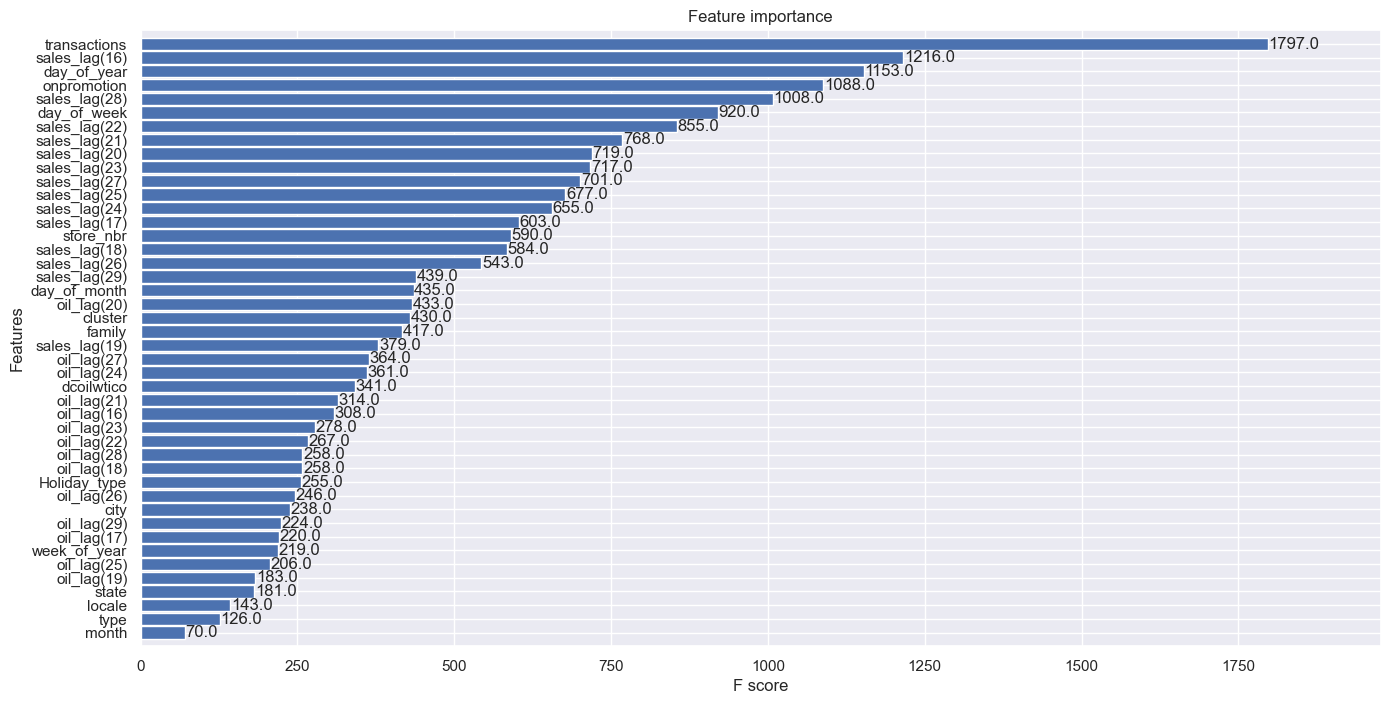

In [1526]:
sns.set(rc = {'figure.figsize':(16, 8)})
_ = xgb.plot_importance(xgb_regressor, height=0.9)

In [1527]:
val_predicted = xgb_regressor.predict(d_validation).tolist()
val_true = y_validation.tolist()

In [1528]:
results = pd.DataFrame({'prediction':val_predicted, 'actual': val_true})
results[results < 0] = 0

In [1529]:
mean_squared_log_error( results['actual'], results['prediction'], squared=False)

0.4839558949299167

In [1530]:
# 0.52 starting from 2016

In [1531]:
submission = pd.read_csv(r"./data/sample_submission.csv")
y_test = xgb_regressor.predict(d_test)
y_test[y_test < 0] = 0
submission['sales'] = y_test
submission.to_csv("submission.csv", index=False)
submission.head()

,id,sales
0,3000888,3.432389
1,3000889,0.544287
2,3000890,3.642372
3,3000891,1864.578613
4,3000892,0.600905


In [1533]:
lst = numerical.remove('sales')